In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from statsmodels.graphics.tsaplots import month_plot
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.stats.mstats import winsorize
import os
from datetime import datetime

import warnings
warnings.filterwarnings('ignore',category=Warning)

### **Data Load and Get Basic Info**

In [4]:
df = pd.read_csv("../data/question4-stock-data.csv")
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
# print the 1 st 5 rows of the dataframe

df.head(20)

,Unnamed: 0,Date,Adj Close,Close,High,Low,Open,Volume
0,0,1980-03-17,2.296798,3.291227,3.344743,3.291227,0.000000,41109.0
1,1,1980-03-18,2.306134,3.304606,3.358122,3.304606,0.000000,9343.0
2,2,1980-03-19,2.306134,3.304606,3.304606,3.304606,3.304606,0.0
3,3,1980-03-20,2.306134,3.304606,3.358122,3.304606,0.000000,10277.0
4,4,1980-03-21,2.362154,3.384880,3.438396,3.384880,0.000000,8409.0
5,5,1980-03-24,2.371490,3.398259,3.451775,3.398259,0.000000,2803.0
6,6,1980-03-25,2.352816,3.371501,3.425017,3.371501,0.000000,27095.0
7,7,1980-03-26,2.352816,3.371501,3.425017,3.371501,0.000000,1869.0
8,8,1980-03-27,2.324807,3.331364,3.384880,3.331364,0.000000,14015.0
9,9,1980-03-28,2.315470,3.317985,3.371501,3.317985,0.000000,36438.0


In [6]:
# get statistical information of the dataframe

df.describe(include='number')

,Unnamed: 0,Adj Close,Close,High,Low,Open,Volume
count,11291.000000,11198.000000,11174.000000,11196.000000,11164.000000,11188.000000,1.114600e+04
mean,5645.000000,63.609130,72.026945,72.503100,71.665079,67.999259,2.144157e+05
std,3259.575279,52.266247,51.259828,51.550735,51.011632,55.834401,3.883662e+05
min,0.000000,2.259452,3.237711,3.237711,3.237711,0.000000,0.000000e+00
25%,2822.500000,19.224636,27.500000,27.789255,27.536156,0.000000,1.350000e+04
50%,5645.000000,50.608900,66.035000,66.724998,65.418751,66.065002,9.032350e+04
75%,8467.500000,104.723621,114.297503,114.892500,113.639999,114.269997,2.915750e+05
max,11290.000000,254.770004,254.770004,255.229996,253.589996,255.000000,1.858270e+07


In [7]:
# check for missing values and data types of the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11291 entries, 0 to 11290
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  11291 non-null  int64         
 1   Date        11181 non-null  datetime64[ns]
 2   Adj Close   11198 non-null  float64       
 3   Close       11174 non-null  float64       
 4   High        11196 non-null  float64       
 5   Low         11164 non-null  float64       
 6   Open        11188 non-null  float64       
 7   Volume      11146 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 705.8 KB




**Missing Values Calculation**

By analyzing the dataset, we can see that there are a few missing values in some columns. Below is the calculation of missing values in each column:

```python


#  for  the DataFrame
missing_values = df.isnull().sum()
print(missing_values)

```
**Weekend Shop Closure Analysis** 

By analyzing the dataset, we observe that the shop remains closed on weekends, specifically on **Saturday and Sunday**. This pattern is evident from the absence or significantly lower number of recorded entries on these days.


In [8]:
missing_values = df.isnull().sum()
missing_values

Unnamed: 0      0
Date          110
Adj Close      93
Close         117
High           95
Low           127
Open          103
Volume        145
dtype: int64

### **Handdle Missing Values**

In [9]:
# Fill Date missing dates
for i in range(1, len(df)):
    if pd.isna(df.loc[i, 'Date']):  
        next_date = df.loc[i - 1, 'Date'] + pd.Timedelta(days=1)
        
        # Skip Saturdays and Sundays
        while next_date.weekday() in [5, 6]:  # 5 = Saturday, 6 = Sunday
            next_date += pd.Timedelta(days=1)
        
        df.loc[i, 'Date'] = next_date



# Fill missing values in the other columns
df.fillna(method='ffill', inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11291 entries, 0 to 11290
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  11291 non-null  int64         
 1   Date        11291 non-null  datetime64[ns]
 2   Adj Close   11291 non-null  float64       
 3   Close       11291 non-null  float64       
 4   High        11291 non-null  float64       
 5   Low         11291 non-null  float64       
 6   Open        11291 non-null  float64       
 7   Volume      11291 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 705.8 KB


### **Exploratory Data Analysis (EDA)**

In [11]:
class TimeSeriesEDA:
    def __init__(self, df, date_column):
        """
        Initialize the EDA class with a DataFrame and the name of the date column.
        Converts the date column to datetime format and sets it as the index.
        """
        self.df = df.copy()
        self.df[date_column] = pd.to_datetime(self.df[date_column])
        self.df.set_index(date_column, inplace=True)
    
    def plot_time_series(self, column1, column2=None): 
        """
        Plot one or two features against time.
        If column2 is provided, both are plotted on the same figure.
        """
        plt.figure(figsize=(12, 6))
        plt.plot(self.df.index, self.df[column1], label=column1, color='blue')
        if column2:
            plt.plot(self.df.index, self.df[column2], label=column2, color='red')
        plt.title(f'{column1} Over Time' + (f' and {column2}' if column2 else ''))
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.legend()
        plt.show()
    
    def plot_volume(self, volume_column):
        """
        Plot trading volume over time to identify patterns and outliers.
        """
        plt.figure(figsize=(12, 6))
        plt.plot(self.df.index, self.df[volume_column], label="Volume", color="orange")
        plt.title("Stock Volume Over Time")
        plt.xlabel("Date")
        plt.ylabel("Volume")
        plt.show()
    
    def plot_all_features(self):
        """
        Plot all numeric features over time to observe general trends.
        """
        self.df.plot(figsize=(20, 8))
        plt.title("Feature Trends Over Time")
        plt.xlabel("Date")
        plt.ylabel("Values")
        plt.grid()
        plt.show()
    
    def plot_box_by_year(self, target_column):
        """
        Boxplot to analyze feature distribution across different years.
        Useful for detecting trends and variations in yearly data.
        """
        _, ax = plt.subplots(figsize=(25, 8))
        sns.boxplot(x=self.df.index.year, y=self.df[target_column], ax=ax)
        plt.title(f'{target_column} Distribution Over Years')
        plt.xlabel('Year')
        plt.ylabel(target_column)
        plt.xticks(rotation=90)
        plt.grid()
        plt.show()
    
    def plot_box_by_month(self, target_column):
        """
        Boxplot to analyze feature distribution across different months.
        Helps identify monthly patterns in the data.
        """
        _, ax = plt.subplots(figsize=(15, 8))
        sns.boxplot(x=self.df.index.month_name(), y=self.df[target_column], ax=ax)
        plt.title(f'{target_column} Distribution Across Months')
        plt.xlabel('Month')
        plt.ylabel(target_column)
        plt.grid()
        plt.show()
    
    def plot_monthly_trends(self, target_column):
        """
        Month plot to visualize seasonal patterns in time series data.
        """
        fig, ax = plt.subplots(figsize=(22, 8))
        period_index = pd.PeriodIndex(self.df.index, freq="M")  # Convert to PeriodIndex
        month_plot(pd.Series(self.df[target_column].values, index=period_index), ylabel=target_column, ax=ax)
        plt.title(f'{target_column} Monthly Trends')
        plt.xlabel("Month")
        plt.ylabel(target_column)
        plt.grid()
        plt.show()

    
    def plot_yearly_avg(self, target_column):
        """
        Line plot of yearly averages to identify long-term trends.
        """
        yearly_avg = self.df[target_column].resample('A').mean()
        yearly_avg.plot(figsize=(12, 6))
        plt.title(f'Yearly Average of {target_column}')
        plt.xlabel("Year")
        plt.ylabel("Average Value")
        plt.grid()
        plt.show()
    
    def plot_quarterly_avg(self, target_column):
        """
        Line plot of quarterly averages to observe intra-year variations.
        """
        quarterly_avg = self.df[target_column].resample('Q').mean()
        quarterly_avg.plot(figsize=(12, 6))
        plt.title(f'Quarterly Average of {target_column}')
        plt.xlabel("Quarter")
        plt.ylabel("Average Value")
        plt.show()
    
    def compute_coefficient_of_variation(self, target_column):
        """
        Compute coefficient of variation (CV) over years to measure volatility.
        """
        df_stats = self.df.groupby(self.df.index.year)[target_column].agg(['mean', 'std'])
        df_stats['CV_pct'] = (df_stats['std'] / df_stats['mean']) * 100
        return df_stats
    
    def plot_coefficient_of_variation(self, target_column):
        """
        Plot coefficient of variation to analyze yearly volatility.
        """
        df_stats = self.compute_coefficient_of_variation(target_column)
        df_stats['CV_pct'].plot(figsize=(12, 6))
        plt.title(f'Yearly Coefficient of Variation of {target_column}')
        plt.xlabel("Year")
        plt.ylabel("CV (%)")
        plt.grid()
        plt.show()
    
    def plot_correlation_heatmap(self):
        """
        Heatmap to visualize correlation between numeric features.
        Helps identify relationships between different variables.
        """
        numeric_df = self.df.select_dtypes(include='number')
        plt.figure(figsize=(8, 6))
        sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
        plt.title('Feature Correlation Heatmap')
        plt.show()

# Example Usage:
# eda = TimeSeriesEDA(df, "date")
# eda.plot_time_series("open", "close")
# eda.plot_correlation_heatmap()

**Plot All Features**

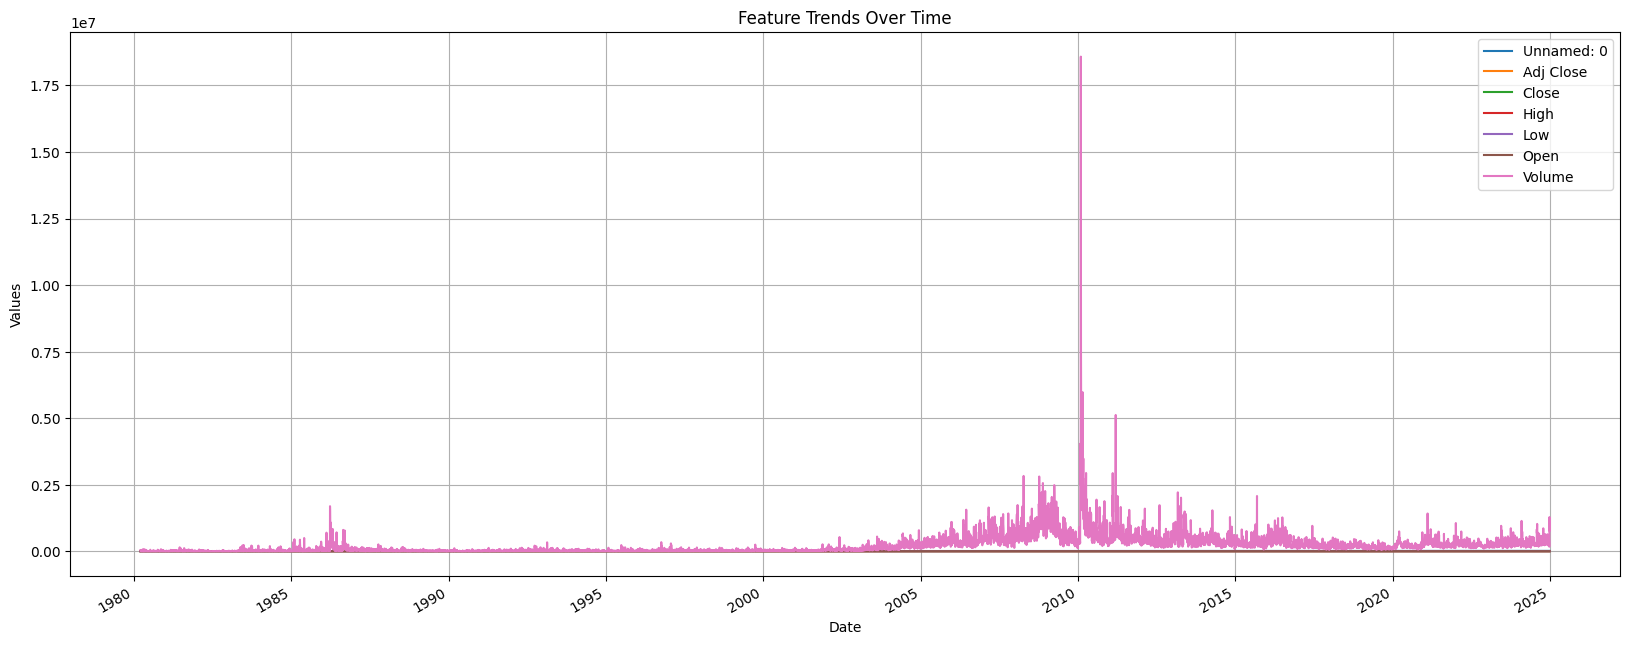

In [12]:
eda = TimeSeriesEDA(df, "Date")
eda.plot_all_features()

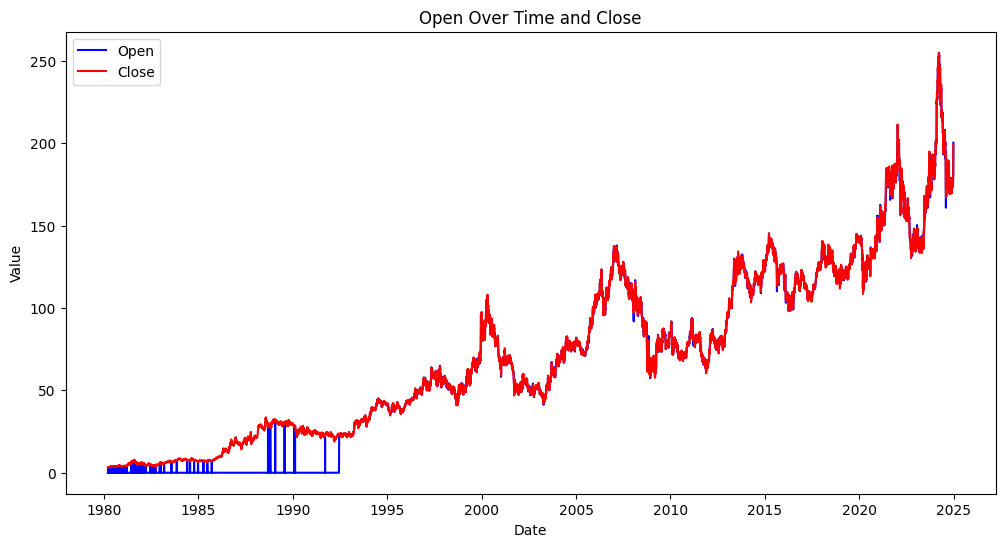

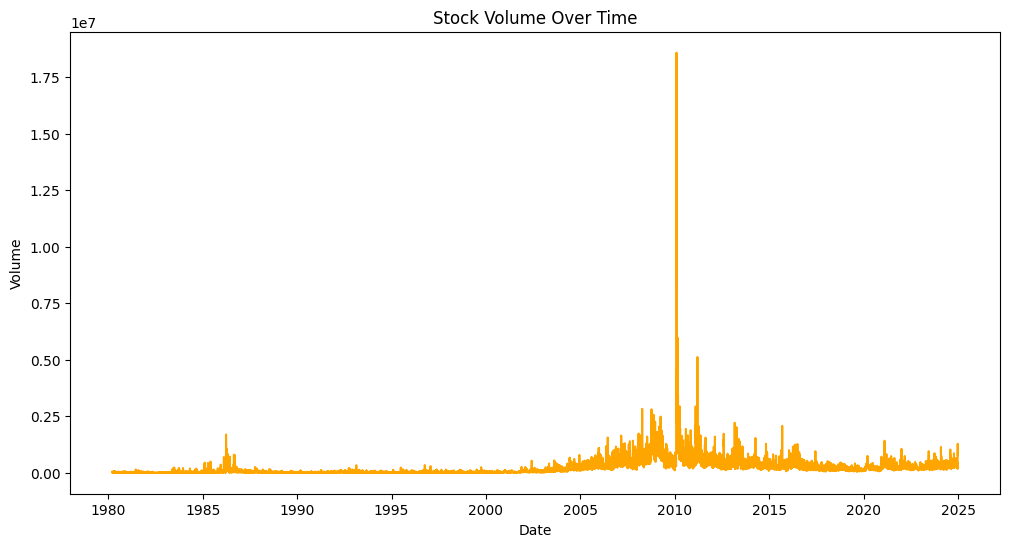

In [13]:
eda.plot_time_series("Open", "Close")
eda.plot_volume("Volume")

**Yearly Variation**

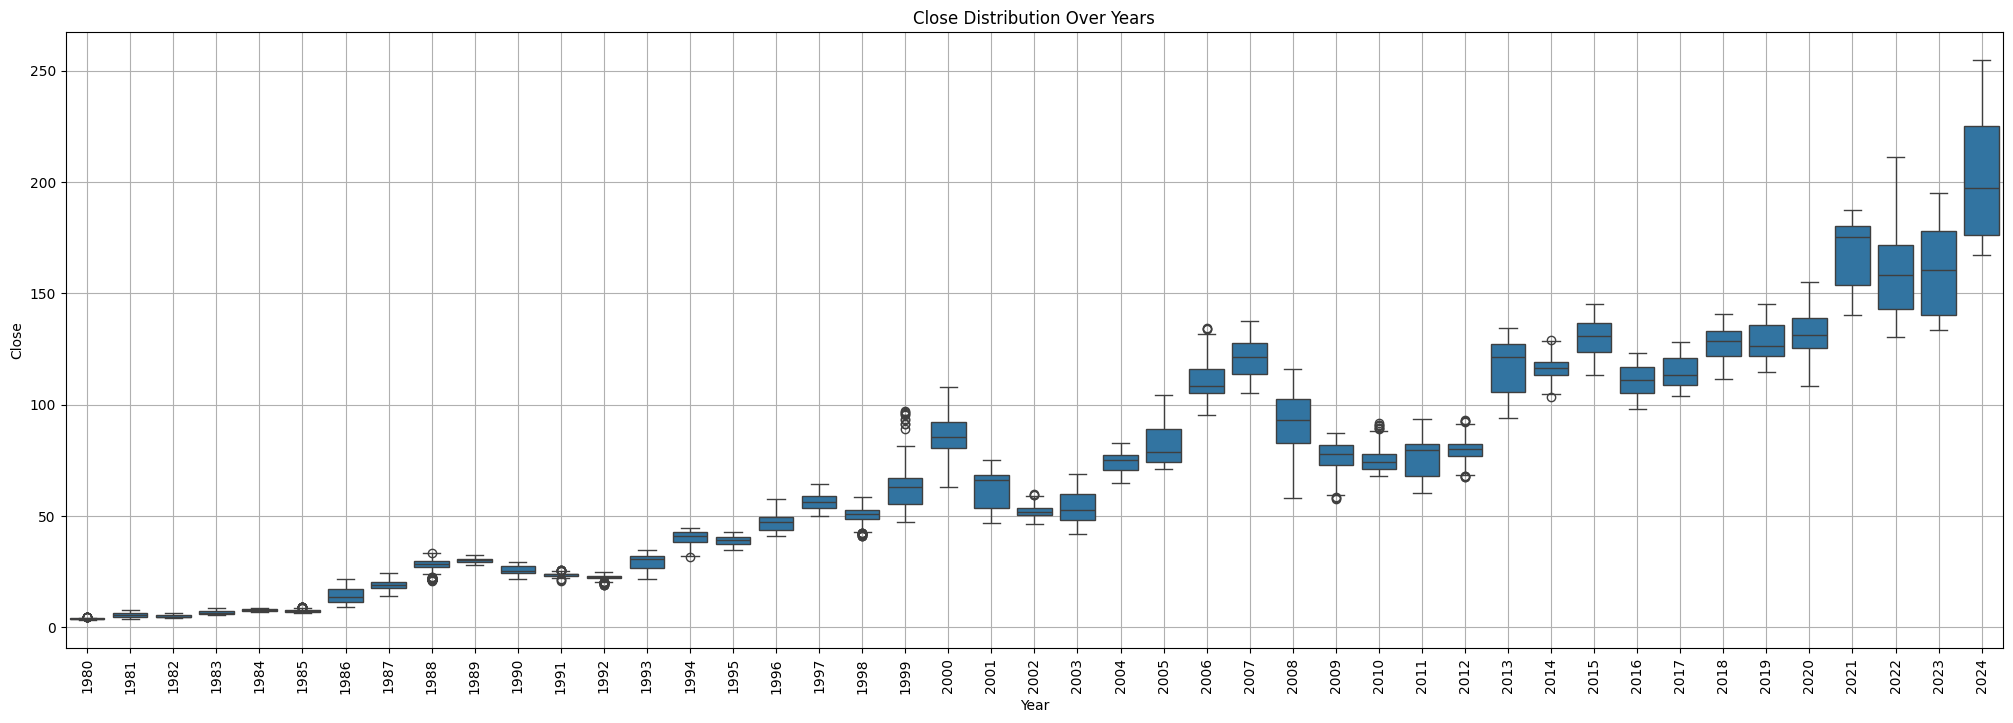

In [14]:
eda.plot_box_by_year("Close")

**Monthly variation and Monthly trends**

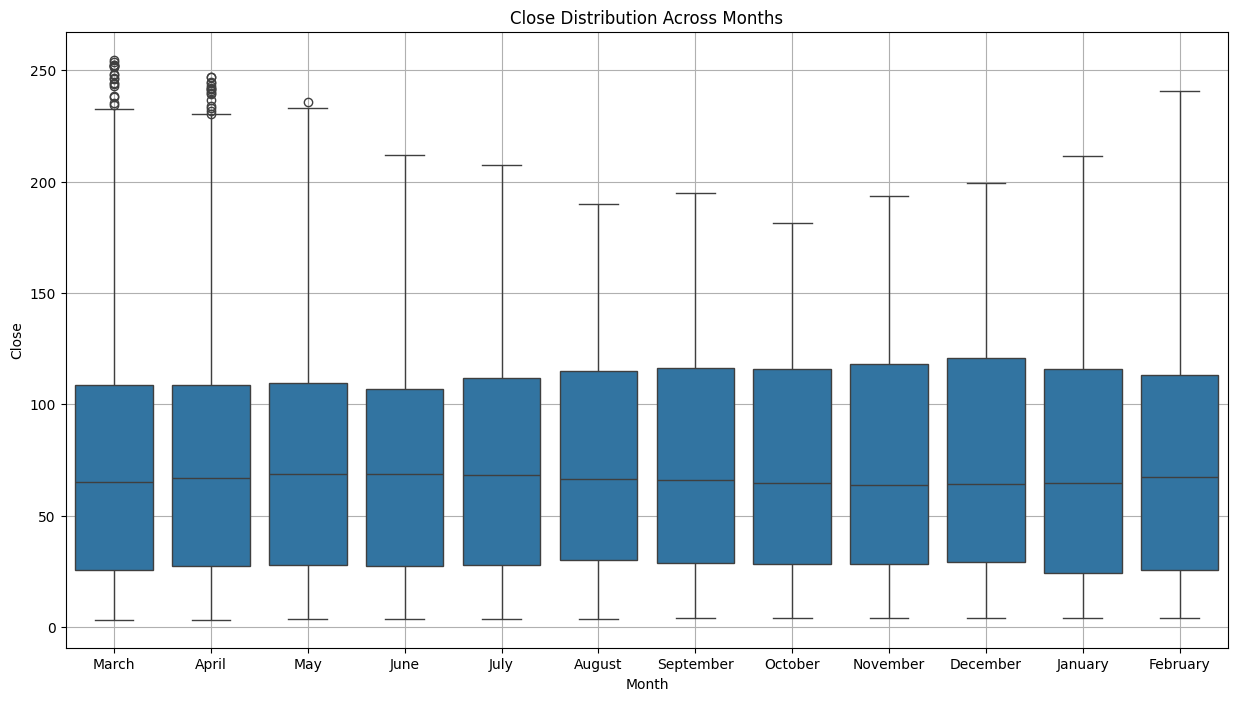

In [15]:
eda.plot_box_by_month("Close")

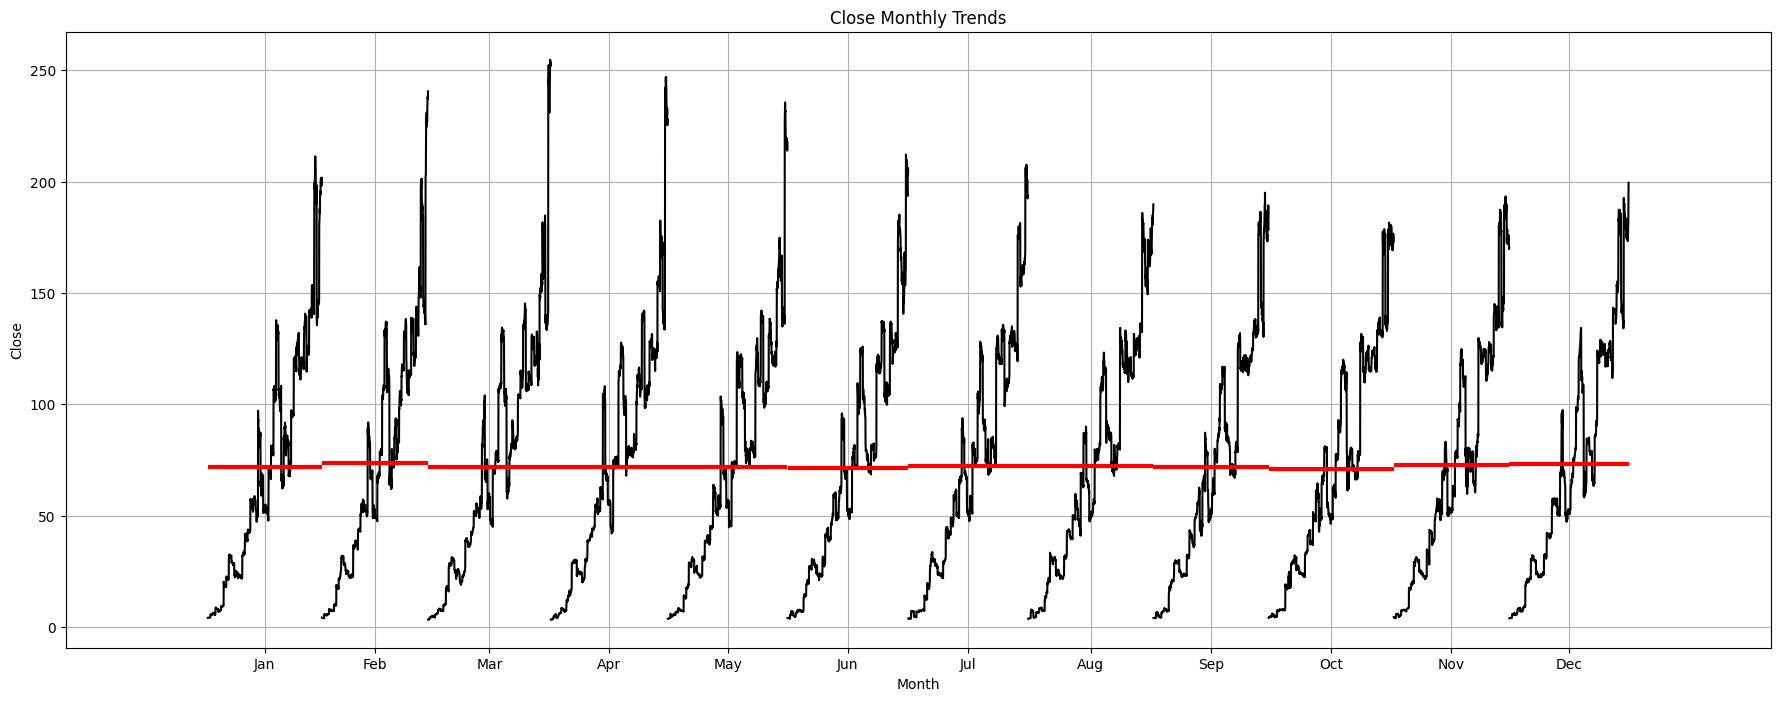

In [16]:
eda.plot_monthly_trends("Close")

**Yearly Average and Quatery Average**

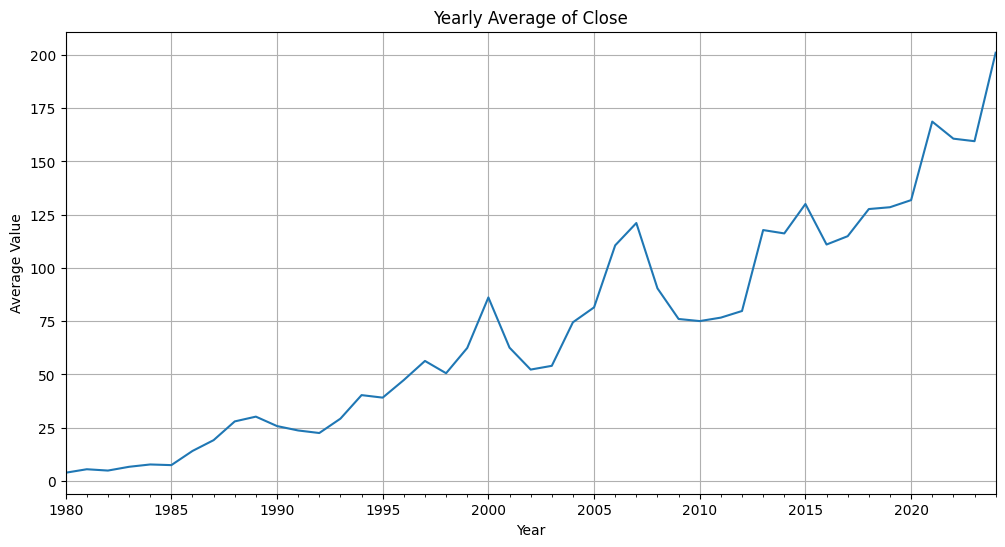

In [17]:
eda.plot_yearly_avg("Close")

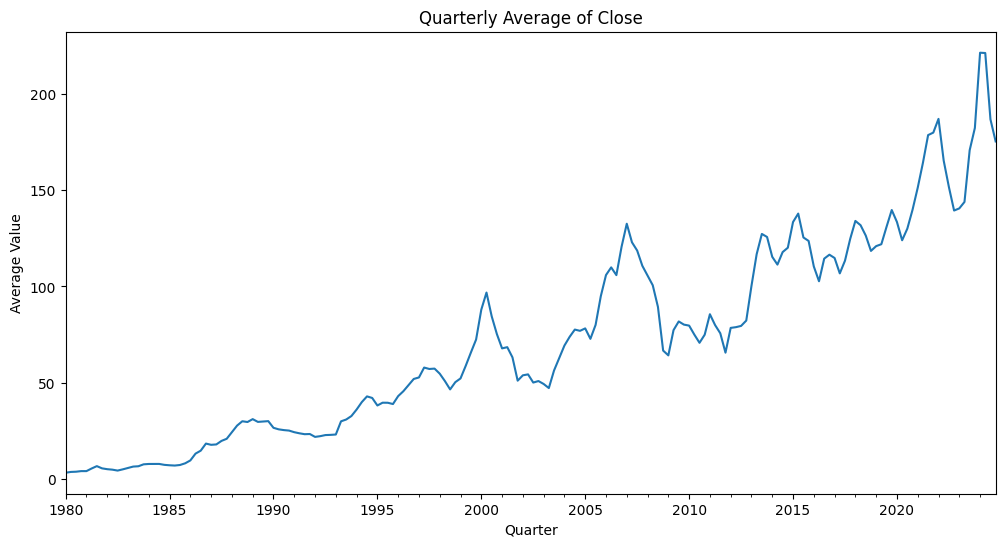

In [18]:
eda.plot_quarterly_avg("Close")

**Coefficient of variation**

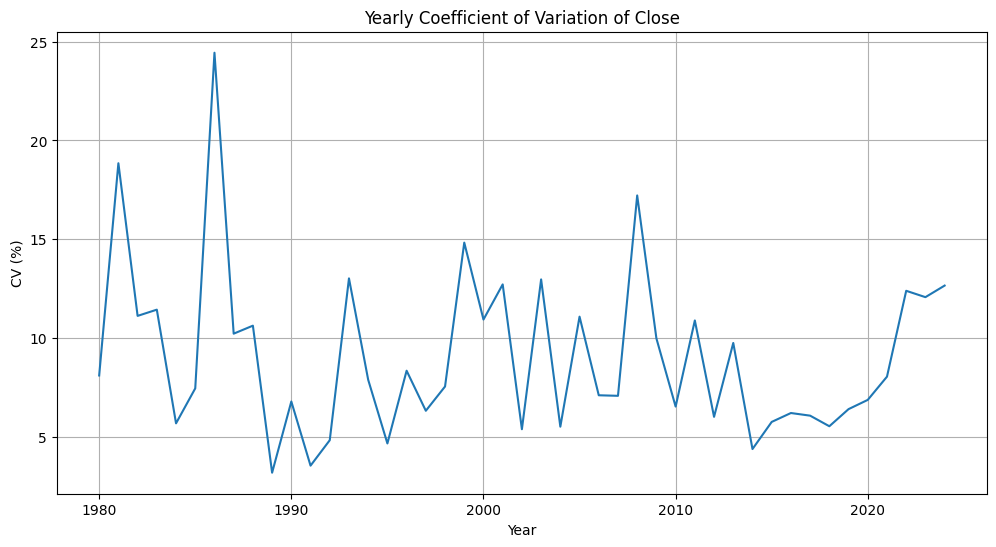

In [19]:
eda.plot_coefficient_of_variation("Close")

**Corelation HeatMap**

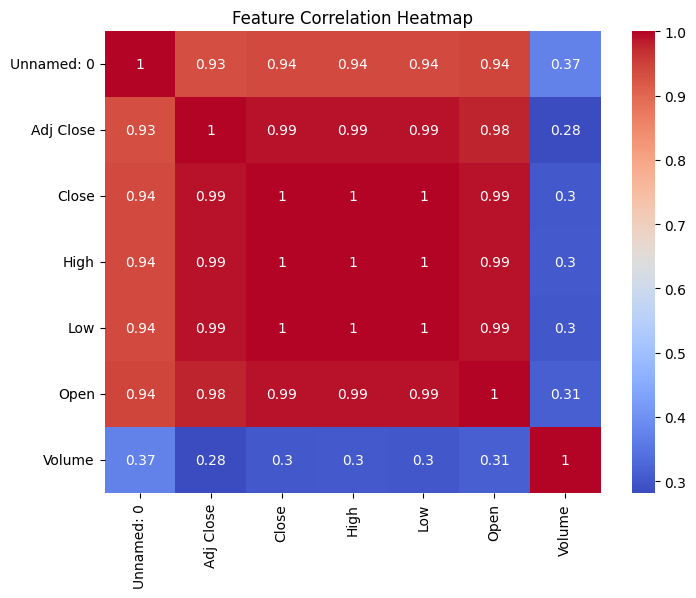

In [20]:
eda.plot_correlation_heatmap()

### **Feature Engineering and Feature Creation**

In [27]:
class TimeSeriesPreprocessor:
    def __init__(self, data, target_column='close'):
        """
        Initialize the Preprocessor with data and target column.
        """
        self.data = data.copy()
        self.target_column = target_column
        self.scaler1 = MinMaxScaler(feature_range=(0, 1))
        self.scaler2 = MinMaxScaler(feature_range=(0, 1))

    def handle_outliers(self, lower_limit=0.005, upper_limit=0.005):
        """
        Uses Winsorization to cap outliers at lower and upper quantiles.
        """
        self.data[self.target_column] = winsorize(self.data[self.target_column], 
                                                  limits=[lower_limit, upper_limit])
    
    def compute_moving_averages(self):
        """
        Adds 5-day, 10-day, and 50-day moving averages.
        """
        for window in [5, 10, 50]:
            self.data[f'ma_{window}'] = self.data[self.target_column].rolling(window=window).mean()
    
    def compute_volatility(self, window=10):
        """
        Computes rolling standard deviation (volatility) over a given window.
        """
        self.data['volatility'] = self.data[self.target_column].rolling(window=window).std()

    def compute_rsi(self, window=14):
        """
        Computes Relative Strength Index (RSI) for stock momentum.
        """
        delta = self.data[self.target_column].diff(1)
        gain, loss = np.where(delta > 0, delta, 0), np.where(delta < 0, -delta, 0)
        avg_gain = pd.Series(gain).rolling(window=window).mean()
        avg_loss = pd.Series(loss).rolling(window=window).mean()
        rs = avg_gain / avg_loss
        self.data['rsi'] = 100 - (100 / (1 + rs))

    def compute_ema(self):
        """
        Adds 10-day and 50-day Exponential Moving Averages.
        """
        for window in [10, 50]:
            self.data[f'ema_{window}'] = self.data[self.target_column].ewm(span=window, adjust=False).mean()

    def compute_daily_return(self):
        """
        Computes daily percentage change in closing price.
        """
        self.data['daily_return'] = self.data[self.target_column].pct_change()

    def add_date_features(self):
        """
        Extracts year, month, day, and weekday from the date column.
        """
        self.data['year'] = self.data['date'].dt.year
        self.data['month'] = self.data['date'].dt.month
        self.data['day'] = self.data['date'].dt.day
        self.data['weekday'] = self.data['date'].dt.weekday

    def handle_missing_values(self):
        """
        Fills missing values using backward fill.
        """
        self.data.fillna(method='bfill', inplace=True)

    def normalize_features(self, feature_columns , target_column):
        """
        Normalizes given feature columns using MinMaxScaler.
        """
        self.data[target_column] = self.scaler1.fit_transform(self.data[[target_column]])
        self.data[feature_columns] = self.scaler2.fit_transform(self.data[feature_columns])
        return self.scaler1

    def create_stacked_sliding_window(self, window_sizes=[30, 60, 90], split_ratio=0.8):
        """
        Creates input sequences (X) and output labels (y) using multiple window sizes.
        Ensures training data is strictly before test data (no data leakage).
        """
        # Ensure we split while keeping time order
        split_idx = int(len(self.data) * split_ratio)
        
        # Keep only training samples that don't use future data
        train_data = self.data.iloc[:split_idx]
        test_data = self.data.iloc[split_idx:]  # Test data starts AFTER train_data

        # Feature columns
        feature_columns = [self.target_column, 'ma_5', 'ma_10', 'ma_50', 'volatility', 'rsi', 'ema_10', 'ema_50', 'daily_return']

        def generate_windows(data):
            X, y = [], []
            for i in range(max(window_sizes), len(data) - 5):  # Ensure future prediction window
                stacked_windows = []
                for window_size in window_sizes:
                    window_data = data[feature_columns].iloc[i - window_size:i].values
                    # Padding smaller windows
                    if window_size < max(window_sizes):
                        padding = np.zeros((max(window_sizes) - window_size, window_data.shape[1]))
                        window_data = np.vstack([padding, window_data])
                    stacked_windows.append(window_data)
                X.append(np.hstack(stacked_windows))
                y.append(data[self.target_column].iloc[i + 5])  # Predicting 5 days ahead
            return np.array(X), np.array(y)

        # Apply the sliding window
        X_train, y_train = generate_windows(train_data)
        X_test, y_test = generate_windows(test_data)

        return X_train, y_train, X_test, y_test

    def process(self):
        """
        Runs all preprocessing steps sequentially.
        """
        self.handle_outliers()
        self.compute_moving_averages()
        self.compute_volatility()
        self.compute_rsi()
        self.compute_ema()
        self.compute_daily_return()
        self.add_date_features()
        self.handle_missing_values()

        #feature_columns = [ 'ma_5', 'ma_10', 'ma_50', 'volatility', 'rsi', 'ema_10', 'ema_50', 'daily_return']
        #self.scaler = self.normalize_features(feature_columns , self.target_column)

        return self.data 



In [29]:
# rename the columns
df = df.rename(columns={'Date': 'date', 'Close': 'close'})

# Initialize Preprocessor
preprocessor = TimeSeriesPreprocessor(df, target_column='close')

# Process Data
processed_data  = preprocessor.process()

scaler = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))
processed_data['close'] = scaler.fit_transform(processed_data[['close']])
processed_data[['close','ma_5', 'ma_10', 'ma_50', 'volatility', 'rsi', 'ema_10', 'ema_50', 'daily_return']] = scaler2.fit_transform(processed_data[['close','ma_5', 'ma_10', 'ma_50', 'volatility', 'rsi', 'ema_10', 'ema_50', 'daily_return']])

processed_data['close']

0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
           ...   
11286    0.781171
11287    0.791382
11288    0.795771
11289    0.867117
11290    0.876791
Name: close, Length: 11291, dtype: float64

In [30]:
# Create sliding window sequences
X_train, y_train, X_test, y_test = preprocessor.create_stacked_sliding_window(window_sizes=[30, 60, 90], split_ratio=0.85)

print("Processed Data Sample:")
print(processed_data.head())

print(f"X_train Shape: {X_train.shape}, y Shape: {y_test.shape}")

Processed Data Sample:
   Unnamed: 0       date  Adj Close  close      High       Low      Open  \
0           0 1980-03-17   2.296798    0.0  3.344743  3.291227  0.000000   
1           1 1980-03-18   2.306134    0.0  3.358122  3.304606  0.000000   
2           2 1980-03-19   2.306134    0.0  3.304606  3.304606  3.304606   
3           3 1980-03-20   2.306134    0.0  3.358122  3.304606  0.000000   
4           4 1980-03-21   2.362154    0.0  3.438396  3.384880  0.000000   

    Volume  ma_5  ma_10  ma_50  volatility  rsi  ema_10  ema_50  daily_return  \
0  41109.0   0.0    0.0    0.0         0.0  1.0     0.0     0.0      0.460544   
1   9343.0   0.0    0.0    0.0         0.0  1.0     0.0     0.0      0.460544   
2      0.0   0.0    0.0    0.0         0.0  1.0     0.0     0.0      0.460544   
3  10277.0   0.0    0.0    0.0         0.0  1.0     0.0     0.0      0.460544   
4   8409.0   0.0    0.0    0.0         0.0  1.0     0.0     0.0      0.460544   

   year  month  day  weekday  
0 

### **Model Building and Evaluation**

In [31]:
input_shape = (X_train.shape[1], X_train.shape[2])  # Dynamically set shape


# Build the Model
model = Sequential()

# First Layer: LSTM with 64 units and return_sequences=True
# This allows passing the sequence to the next LSTM layer
model.add(LSTM(64, return_sequences=True, input_shape=input_shape))

# Second Layer: LSTM with 64 units
# return_sequences=False for the last LSTM layer to output the final hidden state
model.add(LSTM(64, return_sequences=False))

# Third Layer: Dense Layer with ReLU activation
# Helps learn complex features from the outputs of LSTM layers
model.add(Dense(128, activation='relu'))

# Fourth Layer: Dropout for regularization (prevent overfitting)
model.add(Dropout(0.5))

# Final Output Layer: Dense Layer with a single unit for regression (predicting a single value)
model.add(Dense(1))

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Print model summary to inspect the architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 90, 64)         │        23,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,025 (254.00 KB)

 Trainable params: 65,025 (254.00 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Train the model
training = model.fit(X_train, y_train, epochs=50, batch_size=32 , validation_data=(X_test, y_test))


Epoch 1/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - loss: 0.0037 - val_loss: 0.0128
Epoch 2/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 0.0017 - val_loss: 0.0049
Epoch 3/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 0.0012 - val_loss: 0.0158
Epoch 4/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - loss: 0.0011 - val_loss: 0.0043
Epoch 5/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 9.4052e-04 - val_loss: 0.0047
Epoch 6/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 0.0010 - val_loss: 0.0035
Epoch 7/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 9.4944e-04 - val_loss: 0.0048
Epoch 8/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 9.3369e-04 - val_loss: 0.0067
Epoch 9/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 8.9811e-04 - val_loss: 0.0034
Epoch 10/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 8.8846e-04 - val_loss: 0.0022
Epoch 11/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 8.8908e-04 - val_loss: 0.0034
Epoch 

In [33]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
predictions_df = pd.DataFrame(predictions, columns=["Predictions"])
test = y_test.copy()
test = test.reshape(-1, 1)
test = scaler.inverse_transform(test)
test = pd.DataFrame(test, columns=["close"])
test['date'] = df['date'].iloc[-len(test):].values
test['Predictions'] = predictions_df['Predictions']

df_ = df.copy()
df_['close'] = scaler.transform(df_[['close']])

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


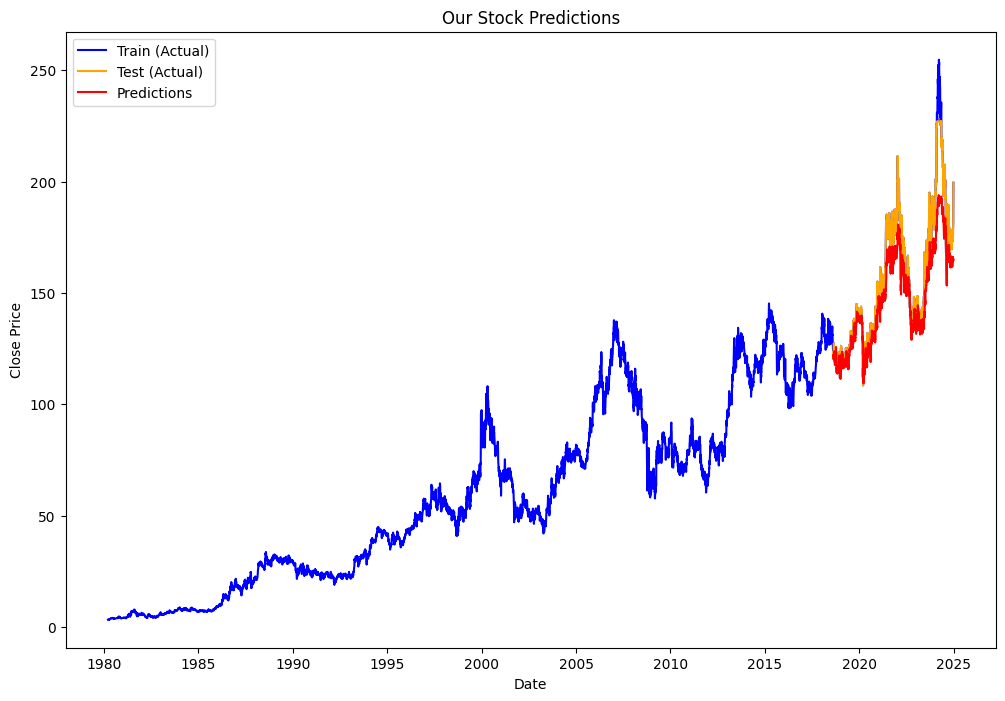

In [35]:
plt.figure(figsize=(12,8))
plt.plot(df['date'], df['close'], label="Train (Actual)", color='blue')
plt.plot(test['date'], test['close'], label="Test (Actual)", color='orange')
plt.plot(test['date'], test['Predictions'], label="Predictions", color='red')
plt.title("Our Stock Predictions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()
